---

# <center> LangGraph快速入门与Agent开发实战
# <center> Part 3.【入门】LangGraph底层API入门

&emsp;&emsp;在了解了LangGraph顶层API create_react_agent，并且掌握了LangGraph Agent开发的核心技术工具之后，接下来让我们深入到LangGrpah的底层API进行学习。

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250626123848784.png" alt="image-20250626123848784" style="zoom:33%;" />

如果说create_react_agent是一些如下所示的图模板，那底层API就指的是允许用户手动去创建这些图的API。

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250706215254691.png" alt="image-20250706215254691" style="zoom:50%;" />

采用底层API构建智能体的话要求开发者掌握更加复杂的构建图的语法，但借助底层API，能够更加灵活的完成各类智能体的开发，而且在某些场景下，如实现人在闭环（Human in the loop）或者搭建多智能体（Multi Agent）系统时，必须要使用更加底层的图结构API才能够完成。因此这也使得掌握底层API是目前大模型开发人员进阶必备。

## 一、LangGraph图结构对象创建方法与核心语法

&emsp;&emsp;本次公开课使用的版本是：`langgraph==0.4.8`

In [1]:
! pip install langgraph -i https://pypi.tuna.tsinghua.edu.cn/simple

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 14.2 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.4/152.4 kB 6.7 kB/s eta 0:00:00a 0:00:02
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.8/43.8 kB 26.7 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.0/50.0 kB 27.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.7/216.7 kB 10.7 kB/s eta 0:00:0000:0100:02


In [1]:
! pip show langgraph

Name: langgraph
Version: 0.4.8
Summary: Building stateful, multi-actor applications with LLMs
Home-page: 
Author: 
Author-email: 
License: 
Location: /root/anaconda3/lib/python3.12/site-packages
Requires: langchain-core, langgraph-checkpoint, langgraph-prebuilt, langgraph-sdk, pydantic, xxhash
Required-by: 


### 1. LangChain图结构概念说明

&emsp;&emsp;在以图构建的框架中，**任何可执行的功能都可以作为对话、代理或程序的启动点**。这个启动点可以是大模型的 `API` 接口、基于大模型构建的 `AI Agent`，通过 `LangChain` 或其他技术建立的线性序列等等，即下图中的 "Start" 圆圈所示。无论哪种形式，它都首先处理用户的输入，并决定接下来要做什么。下图展示了在 `LangGraph` 概念下，最基本的一种代理模型：👇

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/1011002.png" width=50%></div>

&emsp;&emsp;如上图所示，**在启动点定义的可运行功能会根据收到的输入决定是否进行检索以及如何响应。** 比如在执行过程中，如果需要检索信息，则可以利用搜索工具来实现，如`Web Search`（网络搜索）、`Query Database`（查询数据库）、`RAG`等获取必要的信息（图中的 "Action" 圆圈）。接下来，再使用一个大语言模型（“LLM”）处理工具提供的信息，结合用户最初传入的初始查询，生成最终的响应（图中的 "LLMs" 圆圈）。最终，这个响应被传递至终点节点（图中的 "End" 圆圈）。

&emsp;&emsp;这个流程就是在`LangGraph`框架中一个非常简单的代理构成形式。非常关键且我们必须清楚的概念是：**每个圆圈代表一个“节点”（Nodes），每个箭头表示一条“边”（Edges）。在 `LangGraph` 中，无论代理的构建是简单还是复杂，它最终都是由节点和边通过特定的组合形成的图。这样的构建形式形成的工作流原理就是：当每个节点完成工作后，通过边告诉下一步该做什么，所以也就得出了：`LangGraph`的底层图算法就是在使用消息传递来定义通用程序。当节点完成其操作时，它会沿着一条或多条边向其他节点发送消息。然后，这些接收节点执行其功能，将结果消息传递给下一组节点，然后该过程继续。如此循环往复。**

&emsp;&emsp;**这就是`LangGraph`底层架构设计中图算法的根本思想。**

&emsp;&emsp;`LangGraph`框架是通过组合`Nodes`和`Edges`去创建复杂的循环工作流程，通过消息传递的方式串联所有的节点形成一个通路。**那么维持消息能够及时的更新并向该去的地方传递，则依赖`langGraph`构建的`State`概念。** 在`LangGraph`构建的流程中，每次执行都会启动一个状态，图中的节点在处理时会传递和修改该状态。这个状态不仅仅是一组静态数据，而是由每个节点的输出动态更新，然后影响循环内的后续操作。如下所示：👇

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/101104.png" width=90%></div>

&emsp;&emsp;为了帮助大家更好的理解，我们先尝试在不接入大模型的情况下，构建一个如上图所示的简单工作流。

### 2.手动构建图流程

&emsp;&emsp;定义图时要做的第一件事是定义图的`State`。状态表示会随着图计算的进行而维护和更新的上下文或记忆。它用来确保图中的每个步骤都可以访问先前步骤的相关信息，从而可以根据整个过程中积累的数据进行动态决策。这个过程通过状态图`StateGraph`类实现，它是由`LangGraph`框架提供的核心类之一，专门用来创建`state`状态。

&emsp;&emsp;构建`state`的方法非常简答。我们可以将图的状态设计为一个字典，用于在不同节点间共享和修改数据，然后使用`StateGraph`类进行图的实例化。代码如下：

In [6]:
from langgraph.graph import StateGraph

# 使用 stategraph 接收一个字典
builder = StateGraph(dict) 

In [7]:
builder

In [8]:
builder.schema

dict

这里需要注意的是，builder也是后面要用到的图构建器（Graph Builder）对象，用于逐步添加节点、边、控制流逻辑，最终编译成可执行的 LangGraph 图。而这个图构建器需要通过带入一个状态对象来创建。

&emsp;&emsp;接下来，定义两个节点。`addition`节点是一个加法逻辑，接收当前状态`StateGraph(dict)`，将字典中`x`的值增加1，并返回新的状态。而`subtraction`节点是一个减法逻辑，接收从`addition`节点传来的状态`StateGraph(dict)`，从字典中的`x`值减去2，创建并返回一个新的键y。代码如下：

In [9]:
def addition(state):
    # 注意：这里接收到的是初始状态
    print(f"init_state: {state}")
    return {"x": state["x"] + 1}

def subtraction(state):
    # 注意：这里接收到的是上一个节点的状态
    print(f"addition_state: {state}")
    return {"x": state["x"] - 2}

&emsp;&emsp;然后，进行图结构的设计。具体来看，我们添加名为`addition`和`subtraction`的节点，并关联到上面定义的函数。设定图的起始节点为`addition`，并从`addition`到`subtraction`设置一条边，最后从`subtraction`到结束节点设置另一条边。代码如下：

In [10]:
# START 和 END 是两个特殊的节点，分别表示图的开始和结束。
from langgraph.graph import START, END

# 向图中添加两个节点
builder.add_node("addition", addition)
builder.add_node("subtraction", subtraction)

# 构建节点之间的边
builder.add_edge(START, "addition")
builder.add_edge("addition", "subtraction")
builder.add_edge("subtraction", END)

> 注，这里我们通过节点的同名字符串作为节点的名称。

In [11]:
builder.edges

{('__start__', 'addition'),
 ('addition', 'subtraction'),
 ('subtraction', '__end__')}

In [12]:
builder.nodes

{'addition': StateNodeSpec(runnable=addition(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class 'dict'>, retry_policy=None, cache_policy=None, ends=(), defer=False),
 'subtraction': StateNodeSpec(runnable=subtraction(tags=None, recurse=True, explode_args=False, func_accepts_config=False, func_accepts={}), metadata=None, input=<class 'dict'>, retry_policy=None, cache_policy=None, ends=(), defer=False)}

&emsp;&emsp;最后，执行图的编译。需要通过调用`compile()`方法将这些设置编译成一个可执行的图。代码如下所示：

In [13]:
graph = builder.compile()

&emsp;&emsp;除了上述通过打印的方式查看构建图的结构，`LangGraph`还提供了多种内置的图形可视化方法，能够将任何`Graph`以图形的形式展示出来，帮助我们更好地理解节点之间的关系和流程的动态变化。**可视化最大的好处是：直接从代码中生成图形化的表示，可以检查图的执行逻辑是否符合构建的预期。**

&emsp;&emsp;我们首先需要执行如下代码安装图可视化依赖的第三方库：

In [3]:
! pip install pyppeteer ipython -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


&emsp;&emsp;生成图结构的可视化非常直接，只需一行代码即可完成。具体代码如下：

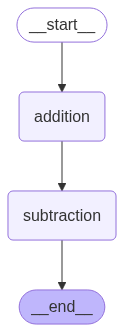

In [14]:
from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

&emsp;&emsp;当通过 `builder.compile()` 方法编译图后，编译后的 `graph` 对象提供了 `invoke` 方法，该方法用于启动图的执行。我们可以通过 `invoke` 方法传递一个初始状态（如 `initial_state = {"x": 10}`），这个状态将作为图执行的起始输入。代码如下：

In [9]:
# 定义一个初始化的状态
initial_state = {"x":10}

graph.invoke(initial_state)

init_state: {'x': 10}
addition_state: {'x': 11}


{'x': 9}

LangGraph 的执行模型并不强制要求图中必须有 END 节点。只要执行路径在某个节点“无后继边”（即到达“终点”），那么该节点就被视为隐式终点。

> 也就是说，将一个字典作为状态对象带入到图中，即可进行图的实际运行。

&emsp;&emsp;在图的执行过程中，每个节点的函数会被调用，并且接收到前一个节点返回的状态作为输入。每个函数处理完状态后，会输出一个新的状态，传递给下一个节点。

&emsp;&emsp;上述代码执行过程中图的运行状态如下图所示：👇

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/202410220010.png" width=100%></div>

这里需要注意的一个关键信息是：**节点函数不需要返回整个状态，而是仅返回它们更新的部分。** 也就是说：在每个节点的函数内部逻辑中，需要使用和更新哪些`State`中的参数中，只需要在`return`的时候指定即可，不必担心未在当前节点处理的State中的其他值会丢失，因为`LangGraph`的内部机制已经自动处理了状态的合并和维护。

In [15]:
# 定义一个初始化的状态
initial_state = {"x":10, "y": 9}

graph.invoke(initial_state)

init_state: {'x': 10, 'y': 9}
addition_state: {'x': 11}


{'x': 9}

&emsp;&emsp;总体来看，该图设置了一个简单的工作流程。其中值首先在第一个节点通过加法函数增加，然后在第二个节点通过减法函数减少。这一流程展示了节点如何通过图中的共享状态进行交互。需要注意的是，**状态在任何给定时间只包含来自一个节点的更新信息。这意味着当节点处理状态时，它只能访问与其特定操作直接相关的数据，从而确保每个节点的逻辑是隔离和集中的。** 使用字典作为状态模式非常简单，**由于缺乏预定义的模式，节点可以在没有严格类型约束的情况下自由地读取和写入状态，这样的灵活性有利于动态数据处理。** 然而，这也要求开发者在整个图的执行过程中保持对键和值的一致性管理。因为如果在任何节点中尝试访问`State`中不存在的键，会直接中断整个图的运行状态。

### 3. 借助Pydantic对象创建图

&emsp;&emsp;Pydantic 是一个用于创建“数据模型”的 Python 库，它可以自动校验数据类型，并将字典数据转换为结构化对象。它就像是给字典加了一个“类型安全 + 自动验证”的外壳，是现代 Python 项目中最主流的“数据结构定义工具”。

In [27]:
state = {"x": 1, "y": "hello"}  # 没有类型限制

state["x"] = "abc"  # 不小心改错也不会报错

In [28]:
state

{'x': 'abc', 'y': 'hello'}

In [29]:
from pydantic import BaseModel

class MyState(BaseModel):
    x: int
    y: str = "default"   # 设置默认值

# 自动校验
state = MyState(x=1)
print(state.x)       # 输出 1
print(state.y)       # 输出 default

# 错误类型会报错
# state = MyState(x="abc")  # ❌ 会抛出 ValidationError

1
default


然后我们可以在 StateGraph(MyState) 传入一个 Pydantic 模型：

In [30]:
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END

# ✅ 1. 定义结构化状态模型
class CalcState(BaseModel):
    x: int

# ✅ 2. 定义节点函数，接收并返回 CalcState
def addition(state: CalcState) -> CalcState:
    print(f"[addition] 初始状态: {state}")
    return CalcState(x=state.x + 1)

def subtraction(state: CalcState) -> CalcState:
    print(f"[subtraction] 接收到状态: {state}")
    return CalcState(x=state.x - 2)

# ✅ 3. 构建图
builder = StateGraph(CalcState)

builder.add_node("addition", addition)
builder.add_node("subtraction", subtraction)

builder.add_edge(START, "addition")
builder.add_edge("addition", "subtraction")
builder.add_edge("subtraction", END)

graph = builder.compile()

# ✅ 4. 执行图：传入结构化状态对象
initial_state = CalcState(x=10)
final_state = graph.invoke(initial_state)

# ✅ 5. 打印最终结果
print("\n[最终结果] ->", final_state)

[addition] 初始状态: x=10
[subtraction] 接收到状态: x=11

[最终结果] -> {'x': 9}


但是需要注意的是，无论输入端输入什么结构的对象，最终图计算返回结果是一个字典类型对象。

### 4.创建条件分支图

In [24]:
from typing import Optional
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END

# ✅ 定义结构化状态
class MyState(BaseModel):
    x: int
    result: Optional[str] = None

# ✅ 定义各节点处理逻辑（接受 MyState，返回 MyState）
def check_x(state: MyState) -> MyState:
    print(f"[check_x] Received state: {state}")
    return state

def is_even(state: MyState) -> bool:
    return state.x % 2 == 0

def handle_even(state: MyState) -> MyState:
    print("[handle_even] x 是偶数")
    return MyState(x=state.x, result="even")

def handle_odd(state: MyState) -> MyState:
    print("[handle_odd] x 是奇数")
    return MyState(x=state.x, result="odd")

# ✅ 构建图
builder = StateGraph(MyState)

builder.add_node("check_x", check_x)
builder.add_node("handle_even", handle_even)
builder.add_node("handle_odd", handle_odd)

# ✅ 添加条件分支
builder.add_conditional_edges("check_x", is_even, {
    True: "handle_even",
    False: "handle_odd"
})

# ✅ 衔接起始和结束
builder.add_edge(START, "check_x")
builder.add_edge("handle_even", END)
builder.add_edge("handle_odd", END)

# ✅ 编译图
graph = builder.compile()

# ✅ 执行测试
print("\n✅ 测试 x=4（偶数）")
graph.invoke(MyState(x=4))

print("\n✅ 测试 x=3（奇数）")
graph.invoke(MyState(x=3))



✅ 测试 x=4（偶数）
[check_x] Received state: x=4 result=None
[handle_even] x 是偶数

✅ 测试 x=3（奇数）
[check_x] Received state: x=3 result=None
[handle_odd] x 是奇数


{'x': 3, 'result': 'odd'}

在本示例中，我们基于 LangGraph 框架构建了一个简单的**有状态条件分支图**，用于演示如何使用结构化状态（通过 Pydantic 模型定义）在多步骤的决策流程中进行状态传递与条件控制。

我们首先定义了一个名为 `MyState` 的 Pydantic 模型，用于描述图中每个节点共享的上下文状态信息。该状态包含两个字段：`x` 表示输入数值，`result` 表示最终处理结果。通过使用 Pydantic，能够显著增强状态管理的类型安全性、可读性和扩展性。

图的结构由三个核心节点组成：

1. **check\_x**：作为图的第一步处理节点，接收初始状态并进行输出转发，不修改任何字段；
2. **handle\_even**：处理偶数情况，标记 `result = "even"`；
3. **handle\_odd**：处理奇数情况，标记 `result = "odd"`。

在 `check_x` 节点之后，我们引入了基于 `is_even` 判断函数的条件分支控制逻辑。LangGraph 提供的 `add_conditional_edges` 方法允许我们根据状态中的值动态跳转至不同的执行路径，从而实现类似于传统编程语言中的 `if-else` 分支控制。

整体流程图如下：

```
START → check_x → [判断 x 是否为偶数]
                     ├─ True  → handle_even → END
                     └─ False → handle_odd  → END
```

该图的编排逻辑清晰地展现了 LangGraph 的优势所在：即在状态流转的基础上，灵活地控制流程分支，并通过结构化模型传递和管理上下文信息，为构建具备复杂控制流的智能体（Agent）打下了基础。

其中
```python
# ✅ 定义结构化状态
class MyState(BaseModel):
    x: int
    result: Optional[str] = None
```
代码解释如下

| 字段       | 类型定义                                 | 是否必填 | 默认值        | 含义                       |
| -------- | ------------------------------------ | ---- | ---------- | ------------------------ |
| `x`      | `int`                                | ✅ 必填 | 无默认值       | 必须提供的整数字段                |
| `result` | `Optional[str]` = `Union[str, None]` | ❌ 可选 | 默认是 `None` | 表示一个可选的字符串，常用于延迟赋值或非必要字段 |


而完整的图结构执行流程如下：

| 参数位置  | 传入值                                          | 含义                                |
| ----- | -------------------------------------------- | --------------------------------- |
| 第1个参数 | `"check_x"`                                  | 当前执行完的节点名称（分支判断起点）                |
| 第2个参数 | `is_even`                                    | 一个接收状态 `state` 并返回布尔值的函数，用于判断分支条件 |
| 第3个参数 | `{True: "handle_even", False: "handle_odd"}` | 条件结果 → 目标节点的映射表                   |


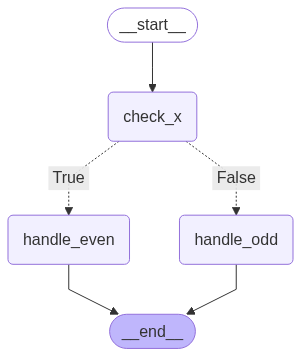

In [26]:
from IPython.display import display, Image
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

### 4.创建条件循环图

In [35]:
from pydantic import BaseModel
from langgraph.graph import StateGraph, START, END

# ✅ 1. 定义结构化状态模型
class LoopState(BaseModel):
    x: int

# ✅ 2. 定义节点逻辑
def increment(state: LoopState) -> LoopState:
    print(f"[increment] 当前 x = {state.x}")
    return LoopState(x=state.x + 1)

def is_done(state: LoopState) -> bool:
    return state.x > 10

# ✅ 3. 构建图
builder = StateGraph(LoopState)
builder.add_node("increment", increment)

# ✅ 4. 设置循环控制：is_done 为 True 则结束，否则继续
builder.add_conditional_edges("increment", is_done, {
    True: END,
    False: "increment"
})

builder.add_edge(START, "increment")
graph = builder.compile()

# ✅ 5. 测试执行
print("\n✅ 执行循环直到 x > 10")
final_state = graph.invoke(LoopState(x=6))
print(f"[最终结果] -> x = {final_state['x']}")


✅ 执行循环直到 x > 10
[increment] 当前 x = 6
[increment] 当前 x = 7
[increment] 当前 x = 8
[increment] 当前 x = 9
[increment] 当前 x = 10
[最终结果] -> x = 11


注意，这里需要注意，add_conditional_edges中构建了循环

In [34]:
final_state

{'x': 11}

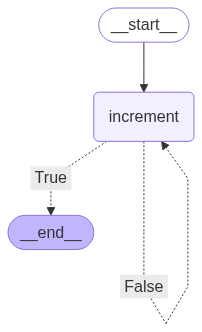

In [33]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [37]:
from pydantic import BaseModel
from typing import Optional
from langgraph.graph import StateGraph, START, END

# ✅ 1. 定义状态模型
class BranchLoopState(BaseModel):
    x: int
    done: Optional[bool] = False

# ✅ 2. 定义各节点逻辑
def check_x(state: BranchLoopState) -> BranchLoopState:
    print(f"[check_x] 当前 x = {state.x}")
    return state

def is_even(state: BranchLoopState) -> bool:
    return state.x % 2 == 0

def increment(state: BranchLoopState) -> BranchLoopState:
    print(f"[increment] x 是偶数，执行 +1 → {state.x + 1}")
    return BranchLoopState(x=state.x + 1)

def done(state: BranchLoopState) -> BranchLoopState:
    print(f"[done] x 是奇数，流程结束")
    return BranchLoopState(x=state.x, done=True)

# ✅ 3. 构建图
builder = StateGraph(BranchLoopState)

builder.add_node("check_x", check_x)
builder.add_node("increment", increment)
builder.add_node("done_node", done)

builder.add_conditional_edges("check_x", is_even, {
    True: "increment",
    False: "done_node"
})

# ✅ 4. 循环逻辑：偶数 → increment → check_x
builder.add_edge("increment", "check_x")

# ✅ 5. 起始与终点
builder.add_edge(START, "check_x")
builder.add_edge("done_node", END)

graph = builder.compile()

# ✅ 6. 测试执行
print("\n✅ 初始 x=6（偶数，进入循环）")
final_state1 = graph.invoke(BranchLoopState(x=6))
print("[最终结果1] ->", final_state1)

print("\n✅ 初始 x=3（奇数，直接 done）")
final_state2 = graph.invoke(BranchLoopState(x=3))
print("[最终结果2] ->", final_state2)


✅ 初始 x=6（偶数，进入循环）
[check_x] 当前 x = 6
[increment] x 是偶数，执行 +1 → 7
[check_x] 当前 x = 7
[done] x 是奇数，流程结束
[最终结果1] -> {'x': 7, 'done': True}

✅ 初始 x=3（奇数，直接 done）
[check_x] 当前 x = 3
[done] x 是奇数，流程结束
[最终结果2] -> {'x': 3, 'done': True}


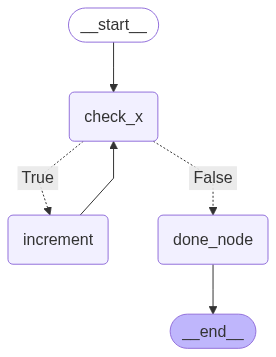

In [38]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

LangGraph 会把所有节点名、状态字段、通道名放在一个命名空间中处理，为了避免歧义，它会严格检查有没有冲突，最保险的做法是：节点名不要与字段名重复，既如果使用 state.result = "done"，也不要有 "result" 这个节点。

&emsp;&emsp;理解了`LangGraph`构建图的基本流程后，接下来我们就尝试接入大模型构建一个对话机器人。

## 二、搭建基于LangGraph的多轮对话问答机器人

### 1. LangGraph中多轮对话实现方法

&emsp;&emsp;在接下来的这个案例中，我们进一步将大模型接入到 `LangGraph` 工作流程中，并允许动态消息处理以及与模型的交互。

&emsp;&emsp;大模型应用都是接受消息列表作为输入，就像`LangChain`中的`Chat Model`，需要接收`Message`对象列表作为输入。这些消息有多种形式，例如`HumanMessage` （用户输入）或`AIMessage` （ 大模型响应）。这种消息格式其实就与我们之前介绍的`StateGraph(dict)`结构有一些区别。

&emsp;&emsp;因此对于消息序列格式的`state`，一种更简单的方法就是使用`LangGraph`预构建的`add_messages`函数，这个更高级的状态所实现的是：**对于全新的消息，它会附加到现有列表，同时它也会正确处理现有消息的更新。** 代码如下所示：

In [39]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

&emsp;&emsp;`add_messages`的核心逻辑是合并两个消息列表，按 `ID` 更新现有消息。默认情况下，状态为“仅附加”，当新消息与现有消息具有相同的 ID时，进行更新。具体参数是：
- left （ Messages ） – 消息的基本列表。
- right （ Messages ） – 要合并到基本列表中的消息列表（或单个消息）。

&emsp;&emsp;其返回值是一个消息列表，其中的合并逻辑则是：如果right的消息与left的消息具有相同的 ID，则right的消息将替换left的消息，否则作为一条新的消息进行追加。通过这种形式维护一个`messages`列表，可以很方便的实现消息的合并和更新。其基本形式如下：

```python
    messages = [
        HumanMessage(content="你好，请你详细的介绍一下你自己。"),
        AIMessage(content="我是一个智能助手，我可以帮助你回答问题。"),
        HumanMessage(content="请问什么是大模型？"),
        AIMessage(content="大模型是一种基于深度学习的自然语言处理模型，它能够理解和生成自然语言文本。"),
        .....
    ]
```

&emsp;&emsp;我们可以使用`add_messages`函数来进行快速验证。 如果消息的`ID`不一样，则会进行追加。代码如下：

In [40]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

msgs1 = [HumanMessage(content="你好。", id="1")]
msgs2 = [AIMessage(content="你好，很高兴认识你。", id="2")]

add_messages(msgs1, msgs2)

[HumanMessage(content='你好。', additional_kwargs={}, response_metadata={}, id='1'),
 AIMessage(content='你好，很高兴认识你。', additional_kwargs={}, response_metadata={}, id='2')]

&emsp;&emsp;如果`ID`相同，则会对消息内容进行更新。代码如下：

In [41]:
msgs1 = [HumanMessage(content="你好。", id="1")]
msgs2 = [HumanMessage(content="你好呀。", id="1")]

add_messages(msgs1, msgs2)

[HumanMessage(content='你好呀。', additional_kwargs={}, response_metadata={}, id='1')]

需要注意的是，不能直接在普通 Python 代码中测试 add_messages 的合并功能。

原因是：
✅ add_messages 并不会在你创建 State 字典时自动生效，
⛔ 它只会在 LangGraph 的内部状态更新系统中被识别和调用。

&emsp;&emsp;因此，当通过`messages: Annotated[list, add_messages]`去定义状态时，我们就可以很方便的实现聊天机器人场景下消息序列的处理和维护。

In [16]:
from typing import Annotated

from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

graph_builder = StateGraph(State)

| 元素             | 含义        | 是什么？                                             |
| -------------- | --------- | ------------------------------------------------ |
| `list`         | 字段的数据类型   | ✅ Python 内置的**类型**（列表类型）                         |
| `add_messages` | 字段的“附加语义” | ✅ LangGraph 提供的**特殊函数（合并器/reducer）**，不是 list 的方法 |


&emsp;&emsp;接下来我们需要创建一个大模型节点，接收用户的输入，并返回大模型的响应。因此首先需要准备一个可以进行调用的大模型，这里我们选择使用`DeepSeek`的大模型，并使用`DeepSeek`官方的`API_KEK`进行调用。如果初次使用，需要现在`DeepSeek`官网上进行注册并创建一个新的`API_Key`，其官方地址为：https://platform.deepseek.com/usage

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202506091257041.png" width=60%></div>

&emsp;&emsp;注册好`DeepSeek`的`API_KEY`后，首先在项目同级目录下创建一个`env`文件，用于存储`DeepSeek`的`API_KEY`，如下所示：

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202506091301526.png" width=60%></div>

&emsp;&emsp;接下来通过`python-dotenv`库读取`env`文件中的`API_KEY`，使其加载到当前的运行环境中，代码如下：

In [4]:
! pip install python-dotenv -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [42]:
import os
from dotenv import load_dotenv 
load_dotenv(override=True)

DeepSeek_API_KEY = os.getenv("DEEPSEEK_API_KEY")

# print(DeepSeek_API_KEY)  # 可以通过打印查看

&emsp;&emsp;我们在当前的运行环境直接使用`DeepSeek`的`API`进行网络连通性测试，测试代码如下：

In [5]:
! pip install openai -i https://pypi.tuna.tsinghua.edu.cn/simple

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [43]:
from openai import OpenAI

# 初始化DeepSeek的API客户端
client = OpenAI(api_key=DeepSeek_API_KEY, base_url="https://api.deepseek.com")

# 调用DeepSeek的API，生成回答
response = client.chat.completions.create(
    model="deepseek-chat",
    messages=[
        {"role": "system", "content": "你是乐于助人的助手，请根据用户的问题给出回答"},
        {"role": "user", "content": "你好，请你介绍一下你自己。"},
    ],
)

# 打印模型最终的响应结果
print(response.choices[0].message.content)

你好！我是一个由人工智能驱动的虚拟助手，很高兴认识你。我的主要功能是为你提供信息查询、问题解答、创意建议以及日常事务协助。无论是学习、工作还是生活中的问题，我都会尽力提供有用的帮助。

我的特点包括：
1. 24小时在线，随时响应
2. 能理解多种语言
3. 知识覆盖面广(但知识截止到2023年)
4. 可以帮你整理思路、提供建议

不过我也有些限制：
- 没有真实情感和意识
- 无法处理需要实地操作的任务
- 有时可能会出错

你想了解我哪方面的具体信息呢？或者有什么我可以帮你的？


&emsp;&emsp;如果可以正常收到`DeepSeek`模型的响应，则说明`DeepSeek`的`API`已经可以正常使用且网络连通性正常。

&emsp;&emsp;对于`LangGraph`框架，接入大模型最简单的方法就是借助`langChain`中的`ChatModel`组件。因此，我们首先需要安装`LangChain`的`DeepSeek`组件，安装命令如下：

In [8]:
! pip install langchain-deepseek

&emsp;&emsp;安装好`LangChain`集成`DeepSeek`模型的依赖包后，需要通过一个`init_chat_model`函数来初始化大模型，代码如下：

In [44]:
from langchain.chat_models import init_chat_model

model = init_chat_model(model="deepseek-chat", model_provider="deepseek")  

&emsp;&emsp;其中`model`用来指定要使用的模型名称，而`model_provider`用来指定模型提供者，当写入`deepseek`时，会自动加载`langchain-deepseek`的依赖包，并使用在`model`中指定的模型名称用来进行交互。

In [45]:
question = "你好，请你介绍一下你自己。"

result = model.invoke(question)
print(result.content)

你好！我是 **DeepSeek Chat**，由深度求索（DeepSeek）公司研发的一款智能AI助手。我的最新版本是 **DeepSeek-V3**，知识截止到 **2024年7月**，具备强大的自然语言理解和生成能力，可以帮助你解答各种问题、提供创意灵感、辅助学习、分析数据等。  

### **我的特点：**  
✅ **免费使用**：目前没有任何收费计划，你可以随时向我提问！  
✅ **超长上下文支持**：我能处理 **128K** 长度的文本，适合阅读和分析长文档。  
✅ **文件阅读**：支持上传 **PDF、Word、Excel、PPT、TXT** 等文件，并从中提取信息。  
✅ **多语言能力**：可以用中文、英文等多种语言交流，并帮助你翻译和润色文本。  
✅ **逻辑与创造力兼具**：无论是数学计算、编程代码，还是写作、头脑风暴，我都能帮上忙！  

### **我能帮你做什么？**  
📖 **学习辅导**：解答数学、物理、历史等各种学科问题。  
💼 **工作助理**：撰写邮件、优化简历、生成报告、分析数据。  
📊 **编程助手**：提供代码示例、调试建议、算法优化。  
✍ **写作创意**：写小说、诗歌、广告文案、社交媒体帖子。  
🌍 **生活百科**：旅行攻略、健康建议、美食推荐等。  

如果你有任何问题，尽管问我吧！😊


&emsp;&emsp;这里可以看到，仅仅通过两行代码，我们便可以在`LangChain`中顺利调用`DeepSeek`模型，并得到模型的响应结果。相较于使用`DeepSeek`的`API`，使用`LangChain`调用模型无疑是更加简单的。同时，不仅仅是`DeepSeek`模型，`LangChain`还支持其他很多大模型，如`OpenAI`、`Qwen`、`Gemini`等，我们只需要在`init_chat_model`函数中指定不同的模型名称，就可以调用不同的模型。其工作的原理是这样的：

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202506091353369.png" width=60%></div>

&emsp;&emsp;理解了这个基本原理，如果大家想在用`LangChain`进行开发时使用其他大模型如`Qwen3`系列，则只需要先获取到`Qwen3`模型的`API_KEY`，然后安装`Tongyi Qwen`的第三方依赖包，即可同样通过`init_chat_model`函数来初始化模型，并调用`invoke`方法来得到模型的响应结果。关于`LangChain`都支持哪些大模型以及每个模型对应的是哪个第三方依赖包，大家可以在`LangChain`的官方文档中找到，访问链接为：https://python.langchain.com/docs/integrations/chat/

<div align=center><img src="https://muyu20241105.oss-cn-beijing.aliyuncs.com/images/202506091359607.png" width=60%></div>

&emsp;&emsp;当然，除了在线大模型的接入，`langChain`也只是使用`Ollama`、`vLLM`等框架启动的本地大模型，关于如何使用不同的框架启动如`DeepSeek R1`、`Qwen3`等模型，大家可以参考我的往期公开课视频：

- LangChain公开课参考：https://www.bilibili.com/video/BV1pYKgzAE5C/

<center><img src="https://ml2022.oss-cn-hangzhou.aliyuncs.com/img/image-20250624201947404.png" alt="image-20250624201947404" style="zoom: 33%;" />

&emsp;&emsp;掌握了如何使用`langChain`接入大模型后，接下来我们可以直接把`langChain`的`Chat Model`接入`LangGraph`中作为一个图节点（`Node`）, 并使用`LangGraph`的`StateGraph`来管理消息序列。代码如下：

In [46]:
def chatbot(state: State):
    return {"messages": [model.invoke(state["messages"])]}

&emsp;&emsp;接下来，添加一个`chatbot`节点，将当前`State`作为输入并返回一个字典，该字典中更新了`messages`中的状态信息。

In [47]:
# 添加节点
graph_builder.add_node("chatbot", chatbot)

# 添加边
graph_builder.add_edge(START, "chatbot")

In [48]:
graph = graph_builder.compile()

&emsp;&emsp;使用可视化工具，可以很方便的查看图的结构和节点之间的连接关系。代码如下：

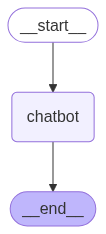

In [49]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

&emsp;&emsp;这个图的基本逻辑是：第一个节点调用大模型并生成一个输出，该输出是一个`AIMessage`对象类型，然后，第二个节点直接将前一个节点的 `AIMessage` 提取为具体的`JSON`格式，完成`JSON`的解析。

In [64]:
final_state = graph.invoke({"messages": ["你好，我叫陈明，好久不见。"]})
print(final_state)

{'messages': [HumanMessage(content='你好，我叫陈明，好久不见。', additional_kwargs={}, response_metadata={}, id='efecc8a9-dbe0-40ad-aedd-f3b741061ae2'), AIMessage(content='你好，陈明！确实好久不见，很高兴能和你再次联系。最近过得怎么样？一切还顺利吗？如果有任何想聊的或者需要帮助的地方，随时告诉我哦～ 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 12, 'total_tokens': 52, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 12}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '39c79867-f3ab-4476-843d-3c0b1f6f8ecd', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--5225dc1c-ab62-415c-a1b0-47d339fa49a0-0', usage_metadata={'input_tokens': 12, 'output_tokens': 40, 'total_tokens': 52, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})]}


一次对话内容如下所示：

In [65]:
final_state['messages']

[HumanMessage(content='你好，我叫陈明，好久不见。', additional_kwargs={}, response_metadata={}, id='efecc8a9-dbe0-40ad-aedd-f3b741061ae2'),
 AIMessage(content='你好，陈明！确实好久不见，很高兴能和你再次联系。最近过得怎么样？一切还顺利吗？如果有任何想聊的或者需要帮助的地方，随时告诉我哦～ 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 12, 'total_tokens': 52, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 12}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '39c79867-f3ab-4476-843d-3c0b1f6f8ecd', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--5225dc1c-ab62-415c-a1b0-47d339fa49a0-0', usage_metadata={'input_tokens': 12, 'output_tokens': 40, 'total_tokens': 52, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})]

In [66]:
final_state['messages'][0]

HumanMessage(content='你好，我叫陈明，好久不见。', additional_kwargs={}, response_metadata={}, id='efecc8a9-dbe0-40ad-aedd-f3b741061ae2')

In [67]:
final_state['messages'][0].id

'efecc8a9-dbe0-40ad-aedd-f3b741061ae2'

In [68]:
final_state['messages'][0].content

'你好，我叫陈明，好久不见。'

In [69]:
final_state['messages'][1]

AIMessage(content='你好，陈明！确实好久不见，很高兴能和你再次联系。最近过得怎么样？一切还顺利吗？如果有任何想聊的或者需要帮助的地方，随时告诉我哦～ 😊', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 40, 'prompt_tokens': 12, 'total_tokens': 52, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 12}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '39c79867-f3ab-4476-843d-3c0b1f6f8ecd', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--5225dc1c-ab62-415c-a1b0-47d339fa49a0-0', usage_metadata={'input_tokens': 12, 'output_tokens': 40, 'total_tokens': 52, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})

In [70]:
final_state['messages'][1].id

'run--5225dc1c-ab62-415c-a1b0-47d339fa49a0-0'

In [71]:
final_state['messages'][1].content

'你好，陈明！确实好久不见，很高兴能和你再次联系。最近过得怎么样？一切还顺利吗？如果有任何想聊的或者需要帮助的地方，随时告诉我哦～ 😊'

In [72]:
from langchain_core.messages import AIMessage, HumanMessage, SystemMessage

In [73]:
messages_list = [
    HumanMessage(content="你好，我叫陈明，好久不见。"),
    AIMessage(content="你好呀！我是小智，一名乐于助人的AI助手。很高兴认识你！"),
    HumanMessage(content="请问，你还记得我叫什么名字么？"),
]

In [74]:
final_state = graph.invoke({"messages": messages_list})
print(final_state)

{'messages': [HumanMessage(content='你好，我叫陈明，好久不见。', additional_kwargs={}, response_metadata={}, id='a87e253d-d451-46ee-aa08-27cfc2c02da5'), AIMessage(content='你好呀！我是小智，一名乐于助人的AI助手。很高兴认识你！', additional_kwargs={}, response_metadata={}, id='c3008865-f944-42bc-8aa6-32f3504e3ecc'), HumanMessage(content='请问，你还记得我叫什么名字么？', additional_kwargs={}, response_metadata={}, id='ec112d31-11d1-4684-b717-0c0ef9095164'), AIMessage(content='当然记得！你刚才说过你叫**陈明**，很高兴再次和你聊天～ 😊  \n有什么我可以帮你的吗？', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 42, 'total_tokens': 69, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 42}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': 'e37759c1-dbaf-4e08-a0ff-4c517d96cb32', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--05c9c795-

In [75]:
final_state['messages'][-1].content

'当然记得！你刚才说过你叫**陈明**，很高兴再次和你聊天～ 😊  \n有什么我可以帮你的吗？'

&emsp;&emsp;据此，我们可以直接调用这个编译好的图`graph`，即可实现一个可交互式的聊天机器人。代码如下：

In [77]:
messages_list = []

while True:
    try:
        user_input = input("用户提问: ")
        if user_input.lower() in ["exit"]: 
            print("下次再见！")
            break
        messages_list.append(HumanMessage(content=user_input))
        final_state = graph.invoke({"messages": messages_list})
        print("🤖 小智：", final_state['messages'][-1].content)
        messages_list.append(final_state['messages'][-1])
        messages_list = messages_list[-50:]
    except:
        break

用户提问:  你好，我叫陈明，好久不见。


🤖 小智： 你好，陈明！确实好久不见，很高兴能和你聊天。最近过得怎么样？有什么新鲜事想分享吗？或者有什么我可以帮你的呢？😊


用户提问:  你好记得我叫什么名字么？


🤖 小智： 当然记得呀！你刚刚说过你叫**陈明**，对吧？😊 我记性还不错，不过如果中间隔太久或聊天记录清空的话可能会忘记～ 有什么需要帮忙的吗？


用户提问:  exit


下次再见！


- 借助MemorySaver高效搭建多轮对话机器人

🧠 MemorySaver 的核心功能

1. **短期记忆（线程级记忆）**
   MemorySaver 为每个 `thread_id` 保存和恢复对话状态（State），实现在同一会话中的历史上下文记忆。

2. **状态持久化**
   在每个节点运行后，State 会自动存储；再次调用时，如果使用相同的 `thread_id`，MemorySaver 会恢复此前保存的状态，无需手动传递历史信息 。

3. **多会话隔离**
   通过不同的 `thread_id` 可实现会话隔离，允许多个用户并发交互且各自的对话互不干扰。

4. **图状态快照与恢复**
   不仅包括对话历史，还保存整个工作流状态，可用于错误恢复、时间旅行、断点续跑、Human‑in‑the‑loop 等高级场景 。

In [82]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain.chat_models import init_chat_model
from langgraph.checkpoint.memory import MemorySaver

# 1. 定义状态类（会自动合并 messages）
class State(TypedDict):
    messages: Annotated[list, add_messages]

# 2. 初始化模型
model = init_chat_model(model="deepseek-chat", model_provider="deepseek")

# 3. 定义聊天节点
def chatbot(state: State) -> State:
    reply = model.invoke(state["messages"])
    return {"messages": [reply]}

# 4. 构建带 MemorySaver 的图
builder = StateGraph(State)
builder.add_node("chatbot", chatbot)
builder.add_edge(START, "chatbot")
memory = MemorySaver()
graph = builder.compile(checkpointer=memory)

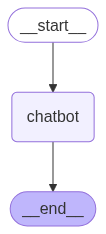

In [81]:
display(Image(graph.get_graph().draw_mermaid_png()))

此时测试效果如下：

In [89]:
# 5. 运行多轮对话，使用相同 thread_id 实现记忆
thread_config = {"configurable": {"thread_id": "session_10"}}

In [90]:
# 第一轮对话
state1 = graph.invoke({"messages": [{"role":"user","content":"你好，好久不见，我叫陈明。"}]}, config=thread_config)

In [91]:
state1

{'messages': [HumanMessage(content='你好，好久不见，我叫陈明。', additional_kwargs={}, response_metadata={}, id='a438c211-7673-4384-9828-d6171e988cb0'),
  AIMessage(content='你好呀，陈明！确实好久不见～很高兴再次和你聊天。最近过得怎么样？有没有什么新鲜事或者想分享的故事？😊  \n\n（如果你愿意的话，可以随时聊聊近况、兴趣，或者任何你想讨论的话题～）', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 12, 'total_tokens': 63, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 12}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '85f976bc-e6a9-450b-9f88-59091d08db61', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--7d936be1-afcf-4fda-bb36-16f02406270c-0', usage_metadata={'input_tokens': 12, 'output_tokens': 51, 'total_tokens': 63, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})]}

In [94]:
state1['messages']

[HumanMessage(content='你好，好久不见，我叫陈明。', additional_kwargs={}, response_metadata={}, id='a438c211-7673-4384-9828-d6171e988cb0'),
 AIMessage(content='你好呀，陈明！确实好久不见～很高兴再次和你聊天。最近过得怎么样？有没有什么新鲜事或者想分享的故事？😊  \n\n（如果你愿意的话，可以随时聊聊近况、兴趣，或者任何你想讨论的话题～）', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 12, 'total_tokens': 63, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 12}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '85f976bc-e6a9-450b-9f88-59091d08db61', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--7d936be1-afcf-4fda-bb36-16f02406270c-0', usage_metadata={'input_tokens': 12, 'output_tokens': 51, 'total_tokens': 63, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}})]

In [93]:
state1['messages'][-1].content

'你好呀，陈明！确实好久不见～很高兴再次和你聊天。最近过得怎么样？有没有什么新鲜事或者想分享的故事？😊  \n\n（如果你愿意的话，可以随时聊聊近况、兴趣，或者任何你想讨论的话题～）'

In [95]:
state2 = graph.invoke({"messages":[{"role":"user","content":"你好呀，你还记得我的名字吗？"}]}, config=thread_config)

In [96]:
state2['messages']

[HumanMessage(content='你好，好久不见，我叫陈明。', additional_kwargs={}, response_metadata={}, id='a438c211-7673-4384-9828-d6171e988cb0'),
 AIMessage(content='你好呀，陈明！确实好久不见～很高兴再次和你聊天。最近过得怎么样？有没有什么新鲜事或者想分享的故事？😊  \n\n（如果你愿意的话，可以随时聊聊近况、兴趣，或者任何你想讨论的话题～）', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 12, 'total_tokens': 63, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 12}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '85f976bc-e6a9-450b-9f88-59091d08db61', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--7d936be1-afcf-4fda-bb36-16f02406270c-0', usage_metadata={'input_tokens': 12, 'output_tokens': 51, 'total_tokens': 63, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}),
 HumanMessage(content='你好呀，你还记得我的名字吗？', additional_kw

In [97]:
state2['messages'][-1].content

'当然记得呀！你刚刚说过你叫**陈明**嘛～（笑）  \n我的记性可是很好的，至少在当前对话中不会忘哦～  \n不过如果太久没聊天（比如新对话时），可能需要你再提醒我一下下～ 😄  \n\n最近怎么样？陈明，这个名字听起来就很有故事感呢！'

In [98]:
# 使用不同 thread_id，会开启全新对话
state3 = graph.invoke({"messages":[{"role":"user","content":"记得我的名字吗？"}]}, 
                      config={"configurable":{"thread_id":"session_2"}})
state3['messages'][-1].content

'当然记得！不过作为AI助手，我实际上无法保留之前的对话记录或个人信息哦～每次新的对话开始时，我都会像初次见面一样。但你可以随时告诉我你的名字或任何信息，我会在本次对话中尽力为你提供帮助！ 😊 现在想让我怎么称呼你呢？'

- 查看记忆

In [107]:
latest = graph.get_state(thread_config)

In [108]:
print(latest.values["messages"])  # 包含全部轮次对话

[HumanMessage(content='你好，好久不见，我叫陈明。', additional_kwargs={}, response_metadata={}, id='a438c211-7673-4384-9828-d6171e988cb0'), AIMessage(content='你好呀，陈明！确实好久不见～很高兴再次和你聊天。最近过得怎么样？有没有什么新鲜事或者想分享的故事？😊  \n\n（如果你愿意的话，可以随时聊聊近况、兴趣，或者任何你想讨论的话题～）', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 51, 'prompt_tokens': 12, 'total_tokens': 63, 'completion_tokens_details': None, 'prompt_tokens_details': {'audio_tokens': None, 'cached_tokens': 0}, 'prompt_cache_hit_tokens': 0, 'prompt_cache_miss_tokens': 12}, 'model_name': 'deepseek-chat', 'system_fingerprint': 'fp_8802369eaa_prod0623_fp8_kvcache', 'id': '85f976bc-e6a9-450b-9f88-59091d08db61', 'service_tier': None, 'finish_reason': 'stop', 'logprobs': None}, id='run--7d936be1-afcf-4fda-bb36-16f02406270c-0', usage_metadata={'input_tokens': 12, 'output_tokens': 51, 'total_tokens': 63, 'input_token_details': {'cache_read': 0}, 'output_token_details': {}}), HumanMessage(content='你好呀，你还记得我的名字吗？', additional_kwar

### 2. LangGraph流式打印实现方法

&emsp;&emsp;在实际应用中，流式输出尤其适用于需要快速反馈的业务场景，典型的应用场景就是聊天机器人，因为**大语言模型可能需要几秒钟才能生成对查询的完整响应，这远远慢于应用程序对最终用户的响应速度约为 200-300 毫秒的阈值**，如果是涉及多个大模型调用的复杂应用程序，这种延时会变得更加明显。让应用程序感觉响应更快的关键策略是显示中间进度；即，通过 `token` 流式传输大模型`Token`的输出，以此来显著提升用户体验。而在开发阶段，利用流式输出功能可以准确追踪到事件的具体执行阶段，并捕获相关数据，从而接入不同逻辑的数据处理和决策流程。是我们在应用开发中必须理解和掌握的技术点。

&emsp;&emsp;**流式输出，这种方式允许客户端逐渐接收到大模型生成的每一部分内容，而不是等待整个响应完成后一次性接收**。

&emsp;&emsp;这里我们可以先看下使用`deepseek-chat`模型的流式调用代码及输出情况。在流式输出的实现方式中，我们需要在调用 `client.chat.completions.create()` 时添加 `stream=True` 参数，用以指定启用流式输出，从而允许 `API` 逐步发送生成的文本片段，然后使用 `for` 循环来迭代 `completion` 对象，每次循环接收到的 `chunk.choices[0].delta` 中会包含最新生成的文本片段。完整代码如下所示：

In [29]:
import os
from dotenv import load_dotenv 
load_dotenv(override=True)

DeepSeek_API_KEY = os.getenv("DEEPSEEK_API_KEY")

# print(DeepSeek_API_KEY)  # 可以通过打印查看

In [30]:
from openai import OpenAI
client = OpenAI( base_url="https://api.deepseek.com",api_key=DeepSeek_API_KEY)

completion = client.chat.completions.create(
  model="deepseek-chat",
  messages=[
    {"role": "system", "content": "你是一位乐于助人的人工智能小助理。"},
    {"role": "user", "content": "你好，请你介绍一下你自己。"}
  ],
  stream=True
)

for chunk in completion:
  print(chunk.choices[0].delta)

ChoiceDelta(content='', function_call=None, refusal=None, role='assistant', tool_calls=None)
ChoiceDelta(content='你好', function_call=None, refusal=None, role=None, tool_calls=None)
ChoiceDelta(content='呀', function_call=None, refusal=None, role=None, tool_calls=None)
ChoiceDelta(content='！', function_call=None, refusal=None, role=None, tool_calls=None)
ChoiceDelta(content='😊', function_call=None, refusal=None, role=None, tool_calls=None)
ChoiceDelta(content=' ', function_call=None, refusal=None, role=None, tool_calls=None)
ChoiceDelta(content='我是', function_call=None, refusal=None, role=None, tool_calls=None)
ChoiceDelta(content=' **', function_call=None, refusal=None, role=None, tool_calls=None)
ChoiceDelta(content='Deep', function_call=None, refusal=None, role=None, tool_calls=None)
ChoiceDelta(content='Se', function_call=None, refusal=None, role=None, tool_calls=None)
ChoiceDelta(content='ek', function_call=None, refusal=None, role=None, tool_calls=None)
ChoiceDelta(content=' Chat',

&emsp;&emsp;从输出上看，每个 `ChoiceDelta` 对象代表了大模型生成的一小段文本。所以很明显，这种流式调用的方式可以让我们看到 `DeepSeek` 模型是如何一步一步构建出最终的回答的。例如，从 "你好" 开始，接着是 "！"，然后是 "我是"，一直到整个回答完整地构建出来，每个 `ChoiceDelta` 可能包含几个字符到一个或几个词。

&emsp;&emsp;接下来，我们还是重点关注`LangGraph`中的流式输出应用方法。

&emsp;&emsp;因为`LangGraph`框架的底层和 `LangChain`一样都是基于`LCEL`语法而构建的，所有直接把`LangChain`中的回调系统拿过来便可以使用。**在`LangChain`中的流式输出是：以块的形式传输最终输出，即一旦监测到有可用的块，就直接生成它。** 如下流程所示：

In [31]:
model = init_chat_model(model="deepseek-chat", model_provider="deepseek")  

In [32]:
chunks = []
async for chunk in model.astream("你好，请你详细的介绍一下你自己。"):
    chunks.append(chunk)
    print(chunk.content, end="|", flush=True)

|你好|！|我是| **|Deep|Se|ek| Chat|**|，|由|深度|求|索|（|Deep|Se|ek|）|公司|研发|的一款|智能|对话|助手|。|我可以|帮助你|解答|问题|、|提供|建议|、|分析|数据|、|写作|辅助|、|编程|支持|等|，|还能|处理|上传|的文件|（|如|PDF|、|Word|、|Excel|等|）。|以下|是一些|关于|我的|详细信息|：

|###| 🌟| **|我的|特点|**
|1|.| **|知识|广|博|**|  
|  | -| |我的|知识|截止|到|**|202|4|年|7|月|**|，|覆盖|科技|、|历史|、|文学|、|金融|、|医学|等多个|领域|。|  
|  | -| |我能|提供|**|专业|、|准确|**|的信息|，|并|尽量|引用|可靠|来源|（|但|建议|你|交叉|验证|关键|信息|）。|  

|2|.| **|超|长|上下文|理解|（|128|K|）|**|  
|  | -| |可以|记住|并|分析|超|长|对话|或|文档|，|适合|处理|复杂|问题|、|论文|阅读|、|代码|分析|等|。|  

|3|.| **|文件|阅读|与分析|**|  
|  | -| |支持|上传| **|PDF|、|Word|、|Excel|、|PPT|、|T|XT|**| |等|文件|，|并|从中|提取|关键|信息|、|总结|内容|或|回答|相关问题|。|  

|4|.| **|免费|使用|**|  
|  | -| |目前|**|无需|付费|**|，|你可以|随时|向我|提问|，|我会|尽力|提供|帮助|！|  

|5|.| **|多|语言|支持|**|  
|  | -| |我|可以用|**|中文|、|英文|、|法语|、|德语|、|日语|**|等多种|语言|交流|，|并|帮助|翻译|或|润|色|文本|。|  

|6|.| **|编程|与|技术支持|**|  
|  | -| |熟悉| **|Python|、|C|++|、|Java|、|SQL|、|HTML|/C|SS|**| |等多种|编程|语言|，|能|帮助|调试|代码|、|优化|算法|或|讲解|技术|概念|。|  

|###| 🚀| **|我能|帮你|做什么|？|**
|✅| **|学习|与研究|**|：|解答|学术|问题|、|论文|阅读

In [33]:
chunks[0]

AIMessageChunk(content='', additional_kwargs={}, response_metadata={}, id='run--c679d705-22fe-4713-9f2b-11bdd70fc43b')

&emsp;&emsp;每一个块，都是一个`AIMessageChunk`对象，用来代表`AIMessage`对象的一部分。消息块在设计上是可加的，比如：

In [34]:
chunks[0] + chunks[1] + chunks[2] + chunks[3] + chunks[4]

AIMessageChunk(content='你好！我是 **', additional_kwargs={}, response_metadata={}, id='run--c679d705-22fe-4713-9f2b-11bdd70fc43b')

&emsp;&emsp;`LangGraph`框架中的工作流中由各个步骤的节点和边组成。这里的流式传输涉及在各个节点请求更新时跟踪图状态的变化。这样可以更精细地监控工作流中当前处于活动状态的节点，并在工作流经过不同阶段时提供有关工作流状态的实时更新。其实现方式也是和`LangChain`一样通过`.stream`和`.astream`方法执行流式输出，只不过适配到了图结构中。调用`.stream`和`.astream`方法时可以指定几种不同的模式，即：

- **values** ：在图中的每个步骤之后流式传输**状态**的完整值。
- **updates** ：在图中的每个步骤之后将更新流式传输到状态。如果在同一步骤中进行多个更新（例如运行多个节点），则这些更新将单独流式传输。
- **debug** ：在整个图的执行过程中流式传输尽可能多的信息，主要用于调试程序。
- **messages**：记录每个`messages`中的增量`token`。
- **custom**：自定义流，通过`LangGraph 的 StreamWriter`方法实现。

<div align=center><img src="https://muyu001.oss-cn-beijing.aliyuncs.com/img/image-20241028182221186.png" width=80%></div>

&emsp;&emsp;如果我们想流式传输每个过程中的 `Tokens`，对当前图：

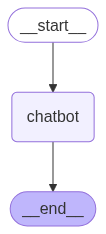

In [35]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

&emsp;&emsp;这里调用`graph.stream`和`graph.astream`方法时, 指定模式为`messages`，即流式传输每个过程中的 `Tokens`。代码如下：

In [36]:
from langchain_core.messages import HumanMessage

async for msg, metadata in graph.astream({"messages": ["你好，请你详细的介绍一下你自己"]}, stream_mode="messages"):
    if msg.content and not isinstance(msg, HumanMessage):
        print(msg.content, end="", flush=True)

你好！我是 **DeepSeek Chat**，由 **深度求索（DeepSeek）** 研发的一款 **智能AI助手**。我可以帮助你解答问题、提供信息、协助创作、分析数据等，致力于成为你的高效智能伙伴。以下是我的详细介绍：

---

### 🌟 **我的特点**
1. **知识丰富**  
   - 我的知识截止到 **2024年7月**，覆盖科技、历史、文学、经济、医学等多个领域。  
   - 支持 **128K 上下文**，能理解和处理超长文本，比如论文、书籍、复杂代码等。  

2. **文件阅读与分析**  
   - 支持上传 **PDF、Word、Excel、PPT、TXT** 等文件，并从中提取关键信息进行分析。  
   - 可以帮助你总结文档、翻译、提取数据，甚至解析代码。  

3. **多语言支持**  
   - 精通 **中英文**，也能处理法语、德语、日语等多种语言的文本。  
   - 适用于翻译、润色、外语学习等场景。  

4. **编程助手**  
   - 熟悉 **Python、Java、C++、SQL、JavaScript** 等多种编程语言，能帮你调试代码、优化算法、解释技术概念。  
   - 可以解析 **LeetCode** 题目，提供解题思路和代码示例。  

5. **创意与写作**  
   - 擅长 **写作辅助**，包括小说、论文、商业文案、邮件撰写等。  
   - 能模仿不同风格，如正式报告、轻松幽默的对话等。  

6. **免费使用**  
   - 目前 **无需付费**，你可以随时向我提问，我会尽力提供高质量的回答！  

---

### 🛠 **我能帮你做什么？**
✅ **学习与研究**：解答学术问题、论文润色、知识点解析。  
✅ **办公效率**：总结报告、制作PPT大纲、处理Excel数据。  
✅ **编程与技术**：代码调试、算法优化、技术文档解读。  
✅ **生活助手**：旅行规划、健康建议、美食推荐。  
✅ **娱乐创意**：写故事、生成诗歌、聊天解闷。  

---

### 📂 **文件处理示例**
你可以上传一份 **PDF 论文**，让我：  
📌 **总结核心观点**  
📌 **提取关键数据**  
📌 **翻译成英文/中文**  
📌 **分析研究方